In [79]:
%pip install --upgrade pip
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Imports & basic config
from __future__ import annotations
import math, random, time, warnings
from dataclasses import dataclass
from typing import Callable, Tuple, Dict, List

import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.set_printoptions(precision=5, suppress=True)

print("Device:", device)


Device: cpu


In [2]:
# Black–Scholes helpers (for implied vol back-out and evaluation)
def bs_price_call(S: float, K: float, T: float, r: float, q: float, sigma: float) -> float:
    """Black–Scholes European call."""
    if T <= 0 or sigma <= 0:
        return max(S*math.exp(-q*T) - K*math.exp(-r*T), 0.0)
    F = S*math.exp((r - q)*T)
    d1 = (math.log(F/K) + 0.5*sigma*sigma*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    from math import erf, sqrt, exp
    N = lambda x: 0.5*(1+erf(x/math.sqrt(2)))
    return math.exp(-r*T)*(F*N(d1) - K*N(d2))

def implied_vol_call(S: float, K: float, T: float, r: float, q: float, price: float,
                     tol: float = 1e-8, max_iter: int = 100) -> float:
    """
    Robust bracketing + bisection for call IV with bound checks.
    - Clamps price to no-arbitrage interval to avoid NaNs.
    - Works for deep ITM/OTM cases and tiny maturities.
    """
    if T <= 0:
        return 0.0

    # No-arbitrage bounds for a call
    disc_q = math.exp(-q*T)
    disc_r = math.exp(-r*T)
    lower = max(0.0, S*disc_q - K*disc_r)
    upper = S*disc_q

    # Clamp price slightly inside bounds
    eps = 1e-12 * max(1.0, upper)
    price = min(max(price, lower + eps), upper - eps)

    # Bracket in vol
    lo, hi = 1e-8, 5.0
    f_lo = bs_price_call(S, K, T, r, q, lo) - price
    f_hi = bs_price_call(S, K, T, r, q, hi) - price

    # If bad bracket (both same sign), expand hi a bit
    tries = 0
    while f_lo * f_hi > 0 and tries < 10:
        hi *= 1.5
        f_hi = bs_price_call(S, K, T, r, q, hi) - price
        tries += 1

    # If still bad, return a tiny vol
    if f_lo * f_hi > 0:
        return max(lo, 1e-8)

    # Bisection
    for _ in range(max_iter):
        mid = 0.5*(lo + hi)
        f_mid = bs_price_call(S, K, T, r, q, mid) - price
        if abs(f_mid) < tol or (hi - lo) < tol*max(1.0, mid):
            return float(max(mid, 1e-8))
        if f_lo * f_mid <= 0:
            hi, f_hi = mid, f_mid
        else:
            lo, f_lo = mid, f_mid

    return float(max(0.5*(lo + hi), 1e-8))



In [3]:
price=bs_price_call(S=100,K=105,T=0.25, r=0.03, q=0.2, sigma=3)
implied_vol_call(S=100,K=105,T=0.25, r=0.03, q=0.2, price=price) # checking that our IV function works

3.000000002137355

In [45]:
# COS method for European call from characteristic function φ(u)
# Reference: Fang & Oosterlee (2008).
def cos_price_call_cf(cf, S, K, T, r, q, L=12.0, N=512):
    if T <= 0: 
        return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0.0)

    x0 = np.log(S) + (r - q)*T
    c1 = x0
    c2 = 0.2 + T

    a = c1 - L*np.sqrt(c2)
    b = c1 + L*np.sqrt(c2)

    # --- ensure [a,b] covers the strike neighborhood ---
    c_raw = float(np.log(K))
    pad = 2.0  # widen by ±2 around logK (robust for short T wings)
    a = min(a, c_raw - pad)
    b = max(b, c_raw + pad)
    # ---------------------------------------------------

    if c_raw >= b:  # payoff zero on [a,b]
        return 0.0
    c = max(c_raw, a); d = b

    k = np.arange(N)
    u = k*np.pi/(b-a)
    u_safe = u.copy(); u_safe[0] = 1.0

    Chi = ( np.cos(u*(d-a))*np.exp(d) - np.cos(u*(c-a))*np.exp(c)
          + u*( np.sin(u*(d-a))*np.exp(d) - np.sin(u*(c-a))*np.exp(c) ) )/(1.0+u*u)

    Psi = (np.sin(u_safe*(d-a)) - np.sin(u_safe*(c-a))) / u_safe
    Psi[0] = (d - c)

    Vk = 2.0/(b-a) * (Chi - K*Psi)
    Vk[0] *= 0.5

    phi = cf(u.astype(np.complex128))
    basis = np.real(phi * np.exp(-1j*u*a))

    price = np.exp(-r*T) * np.sum(Vk * basis)
    return float(max(price, 0.0))




In [46]:
#CNN for calibration (surface -> params), with param transforms
class SurfaceCalibrator(nn.Module):
    def __init__(self, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8,8)),
            nn.Flatten(),
            nn.Linear(32*8*8, 128), nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x: Tensor) -> Tensor:
        # x: [B, 1, nT, nK] of total variance or IV
        return self.net(x)

def train_calibrator(model: nn.Module, loader: DataLoader, val_loader: DataLoader,
                     epochs: int=20, lr: float=3e-3) -> None:
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best = 1e9
    for ep in range(epochs):
        model.train()
        tr_loss=0.0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = F.mse_loss(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tr_loss += loss.item()*xb.size(0)
        model.eval()
        with torch.no_grad():
            vl=0.0; n=0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                vl += F.mse_loss(model(xb), yb, reduction="sum").item()
                n += xb.size(0)
        tr_loss/=len(loader.dataset); vl/=n
        if vl < best: best = vl
        if ep % 5 == 0:
            print(f"Epoch {ep:02d} | train {tr_loss:.5f} | val {vl:.5f}")

class SurfaceDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]


In [113]:
# Utilities to compute IV surfaces & evaluation metrics
CLAMPED = 0

def iv_surface_forward_grid(price_fn, params, S: float, r: float, q: float,
                            m_grid: np.ndarray, tenors: np.ndarray) -> np.ndarray:
    """
    Build IV surface over (T, m) using K = m * F_T. Clamp prices to no-arb bounds
    before IV inversion to avoid plateaus/jumps.
    """
    global CLAMPED
    nT, nM = len(tenors), len(m_grid)
    iv = np.zeros((nT, nM), dtype=np.float64)
    for i, T in enumerate(tenors):
        disc_q = math.exp(-q*T)
        disc_r = math.exp(-r*T)
        FT = S * math.exp((r - q) * T)
        Ks = m_grid * FT
        for j, K in enumerate(Ks):
            p = float(price_fn(S, float(K), float(T), r, q, params))

            # no-arbitrage bounds
            lb = max(0.0, S*disc_q - K*disc_r)
            ub = S*disc_q

            if not np.isfinite(p):
                p = lb + 1e-12
            p_clipped = float(np.clip(p, lb + 1e-12, ub - 1e-12))
            CLAMPED += int(p_clipped != p)

            iv[i, j] = implied_vol_call(S, float(K), float(T), r, q, p_clipped)
    return iv



def iv_rmse(iv_true: np.ndarray, iv_pred: np.ndarray) -> float:
    return float(np.sqrt(np.mean((iv_true - iv_pred)**2)))


### Heston (SV) — calibration via CNN

In [213]:
#Heston CF and per-tenor pricer
@dataclass
class HestonParams:
    kappa: float; theta: float; sigma: float; rho: float; v0: float

def heston_cf(params: HestonParams, S: float, r: float, q: float, T: float):
    kappa, theta, sigma, rho, v0 = params.kappa, params.theta, params.sigma, params.rho, params.v0
    def cf(u: np.ndarray) -> np.ndarray:
        iu = 1j*u
        d = np.sqrt((rho*sigma*iu - kappa)**2 + sigma*sigma*(iu + u*u))
        g = (kappa - rho*sigma*iu - d)/(kappa - rho*sigma*iu + d)
        C = (kappa*theta/(sigma*sigma))*((kappa - rho*sigma*iu - d)*T - 2*np.log((1-g*np.exp(-d*T))/(1-g)))
        D = ((kappa - rho*sigma*iu - d)/(sigma*sigma))*((1 - np.exp(-d*T))/(1 - g*np.exp(-d*T)))
        return np.exp(iu*(np.log(S) + (r - q)*T) + C + D*v0)
    return cf

def heston_price(S: float, K: float, T: float, r: float, q: float, p: HestonParams) -> float:
    cf = heston_cf(p, S, r, q, T)
    N = 2048 if T < 0.08 else (1024 if T < 0.20 else 512)
    L = 14.0
    return cos_price_call_cf(cf, S, K, T, r, q, L=L, N=N)




In [214]:
# Heston synthetic dataset generator
def sample_heston_params(n: int) -> List[HestonParams]:
    out=[]
    for _ in range(n):
        kappa = rng.uniform(0.5, 3.0)
        theta = rng.uniform(0.02, 0.10)
        sigma = rng.uniform(0.2, 1.0)
        rho   = rng.uniform(-0.9, -0.1)
        v0    = rng.uniform(0.01, 0.10)
        if 2*kappa*theta <= sigma*sigma: theta = max(theta, (sigma*sigma)/(2*kappa) + 1e-3)
        out.append(HestonParams(kappa,theta,sigma,rho,v0))
    return out

def make_heston_dataset_norm(N_samples=600, nT=8, nM=11,
                             S_range=(50.0, 200.0), r_range=(-0.01, 0.05),
                             q_range=(0.0, 0.04),
                             T_min=0.05, T_max=1.5, m_grid=(0.8, 1.2)):
    tenors = np.linspace(T_min, T_max, nT)
    m = np.linspace(m_grid[0], m_grid[1], nM)  # forward moneyness
    X = np.zeros((N_samples, 1, nT, nM), np.float32)  # total variance
    y = np.zeros((N_samples, 5), np.float32)
    aux = np.zeros((N_samples, 3), np.float32)        # [S, r, q] per sample

    for i, p in enumerate(sample_heston_params(N_samples)):
        S = rng.uniform(*S_range)
        r = rng.uniform(*r_range)
        q = rng.uniform(*q_range)
        aux[i] = [S, r, q]

        iv = iv_surface_forward_grid(heston_price, p, S, r, q, m, tenors)  # clamps inside


        X[i, 0] = np.maximum(iv, 1e-8)**2 * tenors[:, None]  # store total variance
        y[i] = np.array([p.kappa, p.theta, p.sigma, p.rho, p.v0], np.float32)

    return X, y, tenors, m, aux   # returns m-grid and aux


In [238]:
# === HESTON: fit scalers & rewrap datasets ===
X, y, tenors_h, m_grid, aux = make_heston_dataset_norm(N_samples=600, nT=8, nM=11)

perm = rng.permutation(len(X))
tr, va, te = perm[:400], perm[400:520], perm[520:]

# z-score on TRAIN ONLY
y_mean_h = y[tr].mean(axis=0).astype(np.float32)
y_std_h  = (y[tr].std(axis=0) + 1e-8).astype(np.float32)
y_z      = ((y - y_mean_h) / y_std_h).astype(np.float32)

train_ds = SurfaceDataset(X[tr], y_z[tr])
val_ds   = SurfaceDataset(X[va], y_z[va])
test_ds  = SurfaceDataset(X[te], y_z[te])  # keep z labels for inspection if needed

aux_tr, aux_va, aux_te = aux[tr], aux[va], aux[te]

# === HESTON: z-scored head + un-z & constrain ===
class SurfaceCalibratorZ(nn.Module):
    def __init__(self, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.SiLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.SiLU(),
            nn.AdaptiveAvgPool2d((8,8)),
            nn.Flatten(),
            nn.Linear(32*8*8, 256), nn.SiLU(),
            nn.Linear(256, 128), nn.SiLU(),
            nn.Linear(128, out_dim)   # outputs z-scored params
        )
    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)

def heston_unz_and_constrain(pred_z: torch.Tensor,
                             y_mean: np.ndarray, y_std: np.ndarray) -> torch.Tensor:
    """
    pred_z: [B,5] z-scored. We un-zscore to original scale, then clip to
    realistic bounds instead of using softplus (which inflated values).
    """
    mean = torch.tensor(y_mean, device=pred_z.device)
    std  = torch.tensor(y_std,  device=pred_z.device)
    p = pred_z * std + mean   # back to original scale

    kappa = torch.clamp(p[...,0], 0.05, 5.0)     # mean reversion
    theta = torch.clamp(p[...,1], 1e-4, 0.50)    # long-run var  (0.50 is conservative upper)
    sigma = torch.clamp(p[...,2], 0.05, 1.50)    # vol-of-vol
    rho   = torch.tanh(p[...,3])                 # correlation in (-1,1)
    v0    = torch.clamp(p[...,4], 1e-6, 0.50)    # initial var

    return torch.stack([kappa, theta, sigma, rho, v0], dim=-1)

# === HESTON: train with z-space loss ===
heston_net = SurfaceCalibratorZ(out_dim=5).to(device)

opt = torch.optim.AdamW(heston_net.parameters(), lr=3e-3, weight_decay=1e-4)
for ep in range(120):
    heston_net.train(); tr_loss = 0.0
    for xb, yb in DataLoader(train_ds, batch_size=32, shuffle=True):
        xb, yb = xb.to(device), yb.to(device)           # yb are z-scored
        pred_z = heston_net(xb)
        loss = F.mse_loss(pred_z, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()*xb.size(0)
    # quick val
    heston_net.eval(); vl=0.0; n=0
    with torch.no_grad():
        for xb, yb in DataLoader(val_ds, batch_size=64):
            xb, yb = xb.to(device), yb.to(device)
            vl += F.mse_loss(heston_net(xb), yb, reduction="sum").item()
            n += xb.size(0)
    if ep % 5 == 0:
        print(f"Epoch {ep:02d} | train {tr_loss/len(train_ds):.5f} | val {vl/n:.5f}")


Epoch 00 | train 0.99370 | val 4.58086
Epoch 05 | train 0.64625 | val 3.41362
Epoch 10 | train 0.37328 | val 2.47427
Epoch 15 | train 0.32805 | val 2.20226
Epoch 20 | train 0.27616 | val 1.88239
Epoch 25 | train 0.26835 | val 1.92675
Epoch 30 | train 0.26093 | val 1.74399
Epoch 35 | train 0.26555 | val 1.73486
Epoch 40 | train 0.26012 | val 1.61492
Epoch 45 | train 0.26667 | val 1.61252
Epoch 50 | train 0.24633 | val 1.51817
Epoch 55 | train 0.23311 | val 1.56861
Epoch 60 | train 0.25495 | val 1.43131
Epoch 65 | train 0.26021 | val 1.46747
Epoch 70 | train 0.22034 | val 1.53411
Epoch 75 | train 0.21849 | val 1.63864
Epoch 80 | train 0.23099 | val 1.53030
Epoch 85 | train 0.21587 | val 1.38719
Epoch 90 | train 0.16213 | val 1.44872
Epoch 95 | train 0.15664 | val 1.49277
Epoch 100 | train 0.12638 | val 1.25930
Epoch 105 | train 0.11711 | val 1.19775
Epoch 110 | train 0.10435 | val 1.14442
Epoch 115 | train 0.12244 | val 0.96061


In [239]:
# Heston repricing RMSE (z-scored targets + constrained outputs)
def repricing_rmse_heston_norm(model: nn.Module,
                               X_ds, y_ds, aux_ds,   # X: torch [N,1,nT,nM]
                               tenors, m_grid,
                               S_default=100.0, r_default=0.01, q_default=0.0) -> float:
    """
    Uses heston_unz_and_constrain(pred_z, y_mean_h, y_std_h) to map the
    model's z-scored outputs back to valid Heston params before repricing.
    """
    model.eval()
    errs = []
    with torch.no_grad():
        N = X_ds.shape[0]
        for i in range(N):
            # predict z-scored params and map to valid domain
            xb = X_ds[i:i+1].to(device)              # [1,1,nT,nM]
            pred_z = model(xb)                       # [1,5]
            params_t = heston_unz_and_constrain(pred_z, y_mean_h, y_std_h)[0]  # [5]
            kappa, theta, sigma, rho, v0 = [float(x) for x in params_t.cpu().numpy()]
            P = HestonParams(kappa, theta, sigma, rho, v0)

            # sample-specific market inputs
            if aux_ds is None:
                S, r, q = S_default, r_default, q_default
            else:
                row = aux_ds[i]
                if isinstance(row, torch.Tensor):
                    S, r, q = [float(v) for v in row.tolist()]
                else:
                    S, r, q = [float(v) for v in np.asarray(row).tolist()]

            # repriced IV on (T, m) grid
            iv_hat = iv_surface_forward_grid(heston_price, P, S, r, q, m_grid, tenors)

            # true IV from stored total variance
            tw_true = X_ds[i, 0].cpu().numpy()
            iv_true = np.sqrt(np.maximum(tw_true / tenors[:, None], 1e-12))

            # robust RMSE (ignore any NaNs)
            mask = np.isfinite(iv_true) & np.isfinite(iv_hat)
            errs.append(float(np.sqrt(np.nanmean((iv_true[mask] - iv_hat[mask])**2))))
    return float(np.mean(errs))

rmse_heston = repricing_rmse_heston_norm(heston_net,
                                         test_ds.X, test_ds.y, torch.tensor(aux_te),
                                         tenors_h, m_grid)
print("Heston (forward-moneyness) IV RMSE:", "{:.6e}".format(rmse_heston))


Heston (forward-moneyness) IV RMSE: 7.344718e-02


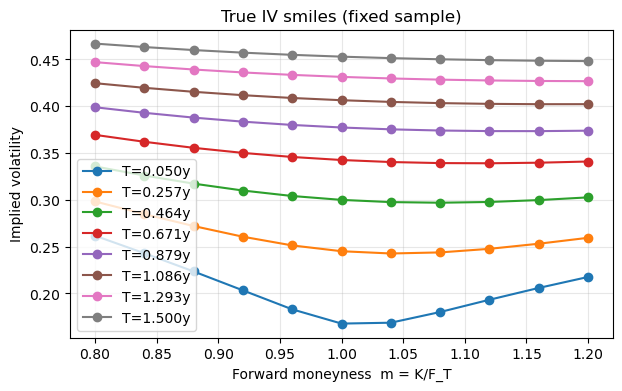

Label repriced clamp count: 0


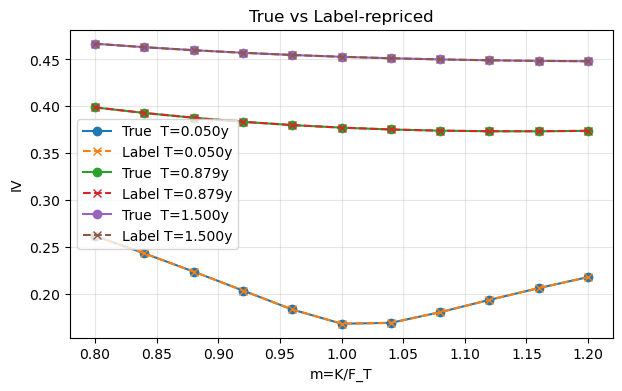

Net repriced clamp count: 0


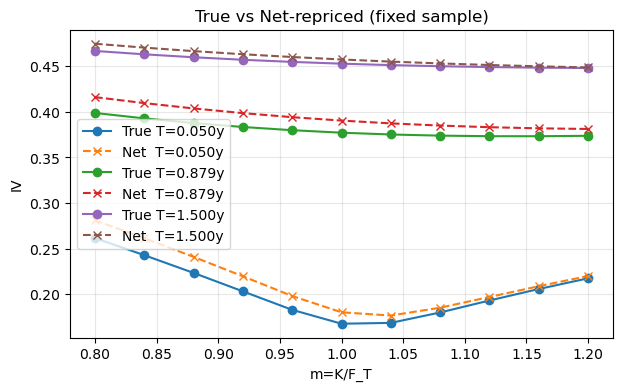

Per-T RMSE (label): [5.7192825411646305e-09, 1.0092858906826657e-08, 1.1300261893470186e-08, 1.7685243274678727e-08, 1.401944544832215e-08, 1.3029725520751953e-08, 2.2230563408769046e-08, 3.7828047946797664e-08]
Per-T RMSE (net):   [0.01285887692111049, 0.01577148498485469, 0.016337509245207923, 0.015298713353550987, 0.013305655314254455, 0.010764088800538755, 0.007938142778680126, 0.005046634086494375]
T=0.050  ATM true=0.1678  label=0.1678  net=0.1803
T=0.879  ATM true=0.3771  label=0.3771  net=0.3904
T=1.500  ATM true=0.4528  label=0.4528  net=0.4574


In [242]:
#  lock ONE sample for all plots
i_fixed = 2
ten = tenors_h
m   = m_grid              # if you use a per-tenor grid, set: m_by_T

# true IV from stored total variance
tw_true = test_ds.X[i_fixed, 0].numpy()
iv_true = np.sqrt(np.maximum(tw_true / ten[:, None], 1e-12))

# convenience
P_true = HestonParams(*test_ds.y[i_fixed].numpy())
S_i, r_i, q_i = map(float, aux_te[i_fixed])

# =====true smiles
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
for t_idx, T in enumerate(ten):
    plt.plot(m, iv_true[t_idx], "o-", label=f"T={T:.3f}y")
plt.xlabel("Forward moneyness  m = K/F_T"); plt.ylabel("Implied volatility")
plt.title("True IV smiles (fixed sample)"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# ===== helper that returns IV + clamp mask
def iv_surface_forward_grid_with_mask(price_fn, params, S, r, q, m_grid, tenors):
    nT, nM = len(tenors), len(m_grid)
    iv = np.zeros((nT, nM), dtype=np.float64)
    mask = np.zeros((nT, nM), dtype=np.int32)
    for i, T in enumerate(tenors):
        disc_q = math.exp(-q*T); disc_r = math.exp(-r*T)
        FT = S * math.exp((r - q) * T)
        Ks = (m_grid * FT).astype(float)
        for j, K in enumerate(Ks):
            p = float(heston_price(S, K, float(T), r, q, params))
            lb = max(0.0, S*disc_q - K*disc_r); ub = S*disc_q
            if not np.isfinite(p): p = lb + 1e-12
            p_c = float(np.clip(p, lb + 1e-12, ub - 1e-12))
            mask[i, j] = int(p_c != p)
            iv[i, j] = implied_vol_call(S, K, float(T), r, q, p_c)
    return iv, mask

# ===== True vs LABEL-repriced =====
# Recover the TRUE (un-zscored) parameters for this test sample
z = test_ds.y[i_fixed].cpu().numpy()                  # z-scored label [5]
p_raw = y_mean_h + y_std_h * z                        # back to original scale

kappa, theta, sigma, rho, v0 = [float(x) for x in p_raw]
# light guards 
theta = max(theta, 1e-4)
sigma = max(sigma, 1e-4)
v0    = max(v0,    1e-6)
rho   = float(np.clip(rho, -0.999, 0.999))

P_true = HestonParams(kappa, theta, sigma, rho, v0)

# market inputs for this sample
S_i, r_i, q_i = map(float, aux_te[i_fixed])

# reprice with the TRUE label params 
iv_label, mask_lab = iv_surface_forward_grid_with_mask(
    heston_price, P_true, S_i, r_i, q_i, m, ten
)
print("Label repriced clamp count:", int(mask_lab.sum()))

mid = len(ten)//2
plt.figure(figsize=(7,4))
for t in [0, mid, -1]:
    plt.plot(m, iv_true[t],  "o-",  label=f"True  T={ten[t]:.3f}y")
    plt.plot(m, iv_label[t], "x--", label=f"Label T={ten[t]:.3f}y")
plt.xlabel("m=K/F_T"); plt.ylabel("IV"); plt.title("True vs Label-repriced")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


# ===== True vs NET-repriced =====
heston_net.eval()
with torch.no_grad():
    pred_z = heston_net(test_ds.X[i_fixed:i_fixed+1].to(device))          # [1,5] in z-space
    params_t = heston_unz_and_constrain(pred_z, y_mean_h, y_std_h)[0]     # [5] valid domain

kappa, theta, sigma, rho, v0 = [float(x) for x in params_t.cpu().numpy()]
P_hat = HestonParams(kappa, theta, sigma, rho, v0)

iv_hat, mask_net = iv_surface_forward_grid_with_mask(
    heston_price, P_hat, S_i, r_i, q_i, m, ten
)
print("Net repriced clamp count:", int(mask_net.sum()))

mid = len(ten)//2
plt.figure(figsize=(7,4))
for t in [0, mid, -1]:
    plt.plot(m, iv_true[t], "o-",  label=f"True T={ten[t]:.3f}y")
    plt.plot(m, iv_hat[t],  "x--", label=f"Net  T={ten[t]:.3f}y")
plt.xlabel("m=K/F_T"); plt.ylabel("IV"); plt.title("True vs Net-repriced (fixed sample)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# quick diagnostics
def per_t_rmse(iv_a, iv_b):
    out=[]
    for t in range(len(ten)):
        mask = np.isfinite(iv_a[t]) & np.isfinite(iv_b[t])
        out.append(float(np.sqrt(np.nanmean((iv_a[t][mask]-iv_b[t][mask])**2))))
    return out

print("Per-T RMSE (label):", per_t_rmse(iv_true, iv_label))
print("Per-T RMSE (net):  ", per_t_rmse(iv_true, iv_hat))

j_atm = int(np.argmin(np.abs(m-1.0)))
for t in [0, mid, -1]:
    print(f"T={ten[t]:.3f}  ATM true={iv_true[t,j_atm]:.4f}  "
          f"label={iv_label[t,j_atm]:.4f}  net={iv_hat[t,j_atm]:.4f}")


In [243]:
# ===== Sanity probe: check scalers, labels, predictions, and repricing =====
heston_net.eval()

# Freeze the scalers onto the model so you can't accidentally use the wrong ones
def attach_scaler_to_model(m, mean, std):
    m.register_buffer("y_mean_h_buf", torch.tensor(mean, dtype=torch.float32))
    m.register_buffer("y_std_h_buf",  torch.tensor(std,  dtype=torch.float32))

if not hasattr(heston_net, "y_mean_h_buf"):
    attach_scaler_to_model(heston_net, y_mean_h, y_std_h)

def unz_constrain_from_model(pred_z):
    return heston_unz_and_constrain(pred_z, heston_net.y_mean_h_buf.cpu().numpy(),
                                           heston_net.y_std_h_buf.cpu().numpy())

i = i_fixed  # chosen sample
xb = test_ds.X[i:i+1].to(device)

with torch.no_grad():
    # network output in z-space
    pred_z = heston_net(xb).cpu().numpy().ravel()

# true (un-zscored) params from the label
z_true = test_ds.y[i].cpu().numpy()
true_params_unz = y_mean_h + y_std_h * z_true

# predicted params (unz + constrained)
with torch.no_grad():
    params_t = unz_constrain_from_model(heston_net(test_ds.X[i:i+1].to(device)))[0].cpu().numpy()

print("Scaler used by model (mean):", getattr(heston_net, "y_mean_h_buf").cpu().numpy())
print("Global y_mean_h you have   :", y_mean_h)
print("DIFF(mean):", np.linalg.norm(getattr(heston_net, "y_mean_h_buf").cpu().numpy() - y_mean_h))

print("\nTRUE params (unz):  [kappa, theta, sigma, rho, v0]:\n", true_params_unz)
print("PRED z      :\n", pred_z)
print("PRED unz+cons:\n", params_t)

# quick IV sanity at ATM across few maturities
S_i, r_i, q_i = map(float, aux_te[i])
ten = tenors_h; m = m_grid
j_atm = int(np.argmin(np.abs(m-1.0)))

# true IV from stored total variance
tw_true = test_ds.X[i,0].cpu().numpy()
iv_true = np.sqrt(np.maximum(tw_true / ten[:,None], 1e-12))

# label repriced IV
P_true = HestonParams(*[float(x) for x in true_params_unz])
iv_lab  = iv_surface_forward_grid(heston_price, P_true, S_i, r_i, q_i, m, ten)

# net repriced IV
P_hat = HestonParams(*[float(x) for x in params_t])
iv_hat = iv_surface_forward_grid(heston_price, P_hat,  S_i, r_i, q_i, m, ten)

print("\nATM IVs (T, true, label, net):")
for t in [0, len(ten)//2, -1]:
    print(f"T={ten[t]:.3f}  {iv_true[t,j_atm]:.4f}  {iv_lab[t,j_atm]:.4f}  {iv_hat[t,j_atm]:.4f}")


Scaler used by model (mean): [ 1.69742  0.15423  0.59045 -0.50057  0.05338]
Global y_mean_h you have   : [ 1.69742  0.15423  0.59045 -0.50057  0.05338]
DIFF(mean): 0.0

TRUE params (unz):  [kappa, theta, sigma, rho, v0]:
 [ 0.62446  0.65281  0.90225 -0.17515  0.02104]
PRED z      :
 [-1.03379  3.00428  1.64102  1.02161 -1.11818]
PRED unz+cons:
 [ 0.96309  0.5      0.9671  -0.26109  0.02428]

ATM IVs (T, true, label, net):
T=0.050  0.1678  0.1678  0.1803
T=0.879  0.3771  0.3771  0.3904
T=1.500  0.4528  0.4528  0.4574


In [244]:
# Price monotonicity at a mid maturity
T_mid = float(tenors_h[len(tenors_h)//2])
S_i, r_i, q_i = map(float, aux_te[0])
FT = S_i * np.exp((r_i - q_i) * T_mid)
K_line = (m_grid * FT).astype(float)

label_params = HestonParams(*test_ds.y[0].numpy())
prices = [heston_price(S_i, float(K), T_mid, r_i, q_i, label_params) for K in K_line]
print("np.diff(prices) should be <= 0:", np.diff(prices))

# IV row stds should now be clearly > 0
tw_true = test_ds.X[0,0].numpy()
iv_true = np.sqrt(np.maximum(tw_true / tenors_h[:,None], 1e-12))
print("std across m (true rows):", [float(np.std(iv_true[t])) for t in range(len(tenors_h))])


np.diff(prices) should be <= 0: [nan nan nan nan nan nan nan nan nan nan]
std across m (true rows): [0.010371264594277344, 0.009420793136725059, 0.008534443533908262, 0.007748423457429636, 0.007070390458083124, 0.006491124656956909, 0.005995807437082562, 0.005569758247913816]


In [245]:
i = 0 
ten, m = tenors_h, m_grid
tw_true = test_ds.X[i,0].numpy()
iv_true = np.sqrt(np.maximum(tw_true / ten[:,None], 1e-12))

print("IV row stats (true):")
for t in range(len(ten)):
    row = iv_true[t]
    print(f"T={ten[t]:.3f}  min={row.min():.6g}  max={row.max():.6g}  std={row.std():.6g}")


IV row stats (true):
T=0.050  min=0.2102  max=0.241046  std=0.0103713
T=0.257  min=0.215735  max=0.243865  std=0.00942079
T=0.464  min=0.220962  max=0.246575  std=0.00853444
T=0.671  min=0.225621  max=0.249177  std=0.00774842
T=0.879  min=0.229955  max=0.251657  std=0.00707039
T=1.086  min=0.233929  max=0.253995  std=0.00649112
T=1.293  min=0.237542  max=0.256176  std=0.00599581
T=1.500  min=0.240814  max=0.258194  std=0.00556976


In [246]:
S,r,q,K = 100.0, 0.01, 0.0, 100.0
P = HestonParams(1.5, 0.05, 0.6, -0.6, 0.04)
p1 = heston_price(S,K,0.25,r,q,P)
p2 = heston_price(S,K,1.00,r,q,P)
print("price T=0.25:", p1, " price T=1.00:", p2)
assert abs(p1 - p2) > 1e-6, "heston_price_tau still not varying with T (stale defs?)."


price T=0.25: 3.9277558968163557  price T=1.00: 8.775570589562038


### Bates (Heston + Merton jumps)

In [254]:
# ===== Bates CF & per-tenor pricer =====
@dataclass
class BatesParams:
    kappa: float; theta: float; sigma: float; rho: float; v0: float
    lam: float;  muJ: float;  sigJ: float

def bates_cf(params: BatesParams, S: float, r: float, q: float, T: float):
    # Heston part
    h = HestonParams(params.kappa, params.theta, params.sigma, params.rho, params.v0)
    h_cf = heston_cf(h, S, r, q, T)
    # Jumps (Merton-type with compensator m1)
    lam, muJ, sigJ = params.lam, params.muJ, params.sigJ
    m1 = math.exp(muJ + 0.5*sigJ*sigJ) - 1.0
    def cf(u: np.ndarray) -> np.ndarray:
        jump = np.exp(lam*T * (np.exp(1j*u*muJ - 0.5*sigJ*sigJ*u*u) - 1.0 - 1j*u*m1))
        return h_cf(u) * jump
    return cf

def bates_price(S: float, K: float, T: float, r: float, q: float, p: BatesParams) -> float:
    cf = bates_cf(p, S, r, q, T)
    N = 2048 if T < 0.08 else (1024 if T < 0.20 else 512)
    L = 14.0
    return cos_price_call_cf(cf, S, K, T, r, q, L=L, N=N)


In [275]:
# ===== Bates dataset (forward-moneyness + clamped IV) =====
def sample_bates_params(n):
    out=[]
    for _ in range(n):
        kappa = rng.uniform(0.5, 3.0)
        theta = rng.uniform(0.02, 0.12)
        sigma = rng.uniform(0.8, 1.4)      # ↑ vol-of-vol
        rho   = rng.uniform(-0.95, -0.5)   # stronger negative skew
        v0    = rng.uniform(0.01, 0.10)
        lam   = rng.uniform(0.6, 2.0)      # ↑ jump intensity
        muJ   = rng.uniform(-0.25, 0.15)   # asymmetry
        sigJ  = rng.uniform(0.30, 0.60)    # larger jump vol
        if 2*kappa*theta <= sigma*sigma:
            theta = max(theta, (sigma*sigma)/(2*kappa) + 1e-3)
        out.append(BatesParams(kappa,theta,sigma,rho,v0,lam,muJ,sigJ))
    return out


def make_bates_dataset_norm(N_samples=800, nT=8, nM=11,
                            S_range=(50.0, 200.0), r_range=(-0.01, 0.05),
                            q_range=(0.0, 0.04),
                            T_min=0.05, T_max=1.5, m_grid=(0.75, 1.25)):
    tenors = np.linspace(T_min, T_max, nT)
    m = np.linspace(m_grid[0], m_grid[1], nM)    # forward moneyness
    X = np.zeros((N_samples,1,nT,nM), np.float32)  # total variance
    y = np.zeros((N_samples,8), np.float32)        # params
    aux = np.zeros((N_samples,3), np.float32)      # [S,r,q]

    for i,p in enumerate(sample_bates_params(N_samples)):
        S = rng.uniform(*S_range); r = rng.uniform(*r_range); q = rng.uniform(*q_range)
        aux[i] = [S,r,q]
        iv = iv_surface_forward_grid(bates_price, p, S, r, q, m, tenors)  # clamps inside
        X[i,0] = np.maximum(iv, 1e-8)**2 * tenors[:,None]
        y[i] = np.array([p.kappa,p.theta,p.sigma,p.rho,p.v0,p.lam,p.muJ,p.sigJ], np.float32)
    return X, y, tenors, m, aux


In [276]:
# ===== Build Bates data + z-scored labels =====
Xb, yb, tenors_b, m_grid_b, aux_b = make_bates_dataset_norm()

perm = rng.permutation(len(Xb))
tr_b, va_b, te_b = perm[:600], perm[600:720], perm[720:]

y_mean_b = yb[tr_b].mean(axis=0).astype(np.float32)
y_std_b  = (yb[tr_b].std(axis=0) + 1e-8).astype(np.float32)
y_z_b    = ((yb - y_mean_b) / y_std_b).astype(np.float32)

ds_tr_b = SurfaceDataset(Xb[tr_b], y_z_b[tr_b])
ds_va_b = SurfaceDataset(Xb[va_b], y_z_b[va_b])
ds_te_b = SurfaceDataset(Xb[te_b], y_z_b[te_b])

aux_tr_b, aux_va_b, aux_te_b = aux_b[tr_b], aux_b[va_b], aux_b[te_b]
# ===== Model & training =====
bates_net = SurfaceCalibratorZ(out_dim=8).to(device)

def attach_bates_scaler_to_model(m, mean, std):
    m.register_buffer("y_mean_b_buf", torch.tensor(mean, dtype=torch.float32))
    m.register_buffer("y_std_b_buf",  torch.tensor(std,  dtype=torch.float32))

attach_bates_scaler_to_model(bates_net, y_mean_b, y_std_b)


opt = torch.optim.AdamW(bates_net.parameters(), lr=3e-3, weight_decay=1e-4)
for ep in range(50):
    bates_net.train(); tr_loss=0.0
    for xb, yb in DataLoader(ds_tr_b, batch_size=32, shuffle=True):
        xb, yb = xb.to(device), yb.to(device)
        pred_z = bates_net(xb)
        loss = F.mse_loss(pred_z, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()*xb.size(0)
    bates_net.eval(); vl=0.0; n=0
    with torch.no_grad():
        for xb, yb in DataLoader(ds_va_b, batch_size=64):
            xb, yb = xb.to(device), yb.to(device)
            vl += F.mse_loss(bates_net(xb), yb, reduction="sum").item(); n += xb.size(0)
    if ep % 5 == 0:
        print(f"[Bates] Epoch {ep:02d} | train {tr_loss/len(ds_tr_b):.4f} | val {vl/n:.4f}")
# ===== Bates un-z + constraints =====
def bates_unz_and_constrain_from_model(pred_z: torch.Tensor, net: nn.Module) -> torch.Tensor:
    """
    Un-zscore using the model's own Bates scalers, then clip to realistic bounds.
    Order: [kappa, theta, sigma, rho, v0, lam, muJ, sigJ]
    """
    mean = net.y_mean_b_buf
    std  = net.y_std_b_buf
    p = pred_z * std + mean

    # Stronger floors to avoid IV≈0 collapse during debugging
    kappa = torch.clamp(p[...,0], 0.05, 5.0)
    theta = torch.clamp(p[...,1], 0.01, 0.50)   # ↑
    sigma = torch.clamp(p[...,2], 0.15, 1.50)   # ↑
    rho   = torch.tanh(p[...,3])
    v0    = torch.clamp(p[...,4], 0.01, 0.50)   # ↑
    lam   = torch.clamp(p[...,5], 0.00, 2.00)
    muJ   = torch.clamp(p[...,6], -0.50, 0.50)
    sigJ  = torch.clamp(p[...,7], 0.05, 1.00)   # ↑

    return torch.stack([kappa,theta,sigma,rho,v0,lam,muJ,sigJ], dim=-1)


[Bates] Epoch 00 | train 0.9293 | val 6.5315
[Bates] Epoch 05 | train 0.7262 | val 5.3803
[Bates] Epoch 10 | train 0.6395 | val 4.3165
[Bates] Epoch 15 | train 0.5353 | val 4.3612
[Bates] Epoch 20 | train 0.5479 | val 4.1501
[Bates] Epoch 25 | train 0.5344 | val 4.3871
[Bates] Epoch 30 | train 0.5407 | val 4.0945
[Bates] Epoch 35 | train 0.5135 | val 4.1077
[Bates] Epoch 40 | train 0.5095 | val 4.1125
[Bates] Epoch 45 | train 0.5111 | val 3.9716


In [277]:
# ===== Bates repricing RMSE =====
def repricing_rmse_bates_norm(model: nn.Module,
                              X_ds, y_ds, aux_ds,
                              tenors, m_grid,
                              S_default=100.0, r_default=0.01, q_default=0.0) -> float:
    model.eval(); errs=[]
    with torch.no_grad():
        N = X_ds.shape[0]
        for i in range(N):
            xb = X_ds[i:i+1].to(device)
            pred_z = model(xb)
            params_t = bates_unz_and_constrain_from_model(pred_z, model)[0].cpu().numpy()

            P = BatesParams(*[float(v) for v in params_t])

            if aux_ds is None:
                S, r, q = S_default, r_default, q_default
            else:
                row = aux_ds[i]
                if isinstance(row, torch.Tensor): S, r, q = [float(v) for v in row.tolist()]
                else:                               S, r, q = [float(v) for v in np.asarray(row).tolist()]

            iv_hat = iv_surface_forward_grid(bates_price, P, S, r, q, m_grid, tenors)
            tw_true = X_ds[i,0].cpu().numpy()
            iv_true = np.sqrt(np.maximum(tw_true / tenors[:,None], 1e-12))
            mask = np.isfinite(iv_true) & np.isfinite(iv_hat)
            errs.append(float(np.sqrt(np.nanmean((iv_true[mask]-iv_hat[mask])**2))))
    return float(np.mean(errs))

rmse_bates = repricing_rmse_bates_norm(bates_net, ds_te_b.X, ds_te_b.y, torch.tensor(aux_te_b),
                                       tenors_b, m_grid_b)
print("Bates (forward-moneyness) IV RMSE:", "{:.6e}".format(rmse_bates))



Bates (forward-moneyness) IV RMSE: 2.595309e-02


In [278]:
# Helper: IV surface + clamp mask using clamped IV inversion
def iv_surface_forward_grid_with_mask(price_fn, params, S, r, q, m_grid, tenors):
    nT, nM = len(tenors), len(m_grid)
    iv = np.zeros((nT, nM), dtype=np.float64)
    mask = np.zeros((nT, nM), dtype=np.int32)
    for i, T in enumerate(tenors):
        disc_q = math.exp(-q*T); disc_r = math.exp(-r*T)
        FT = S * math.exp((r - q) * T)
        Ks = (m_grid * FT).astype(float)
        for j, K in enumerate(Ks):
            p = float(bates_price(S, K, float(T), r, q, params))
            lb = max(0.0, S*disc_q - K*disc_r); ub = S*disc_q
            if not np.isfinite(p): p = lb + 1e-12
            p_c = float(np.clip(p, lb + 1e-12, ub - 1e-12))
            mask[i, j] = int(p_c != p)
            iv[i, j] = implied_vol_call(S, K, float(T), r, q, p_c)
    return iv, mask

def per_t_rmse(iv_a, iv_b):
    out=[]
    for t in range(iv_a.shape[0]):
        m = np.isfinite(iv_a[t]) & np.isfinite(iv_b[t])
        out.append(float(np.sqrt(np.nanmean((iv_a[t][m]-iv_b[t][m])**2))))
    return out


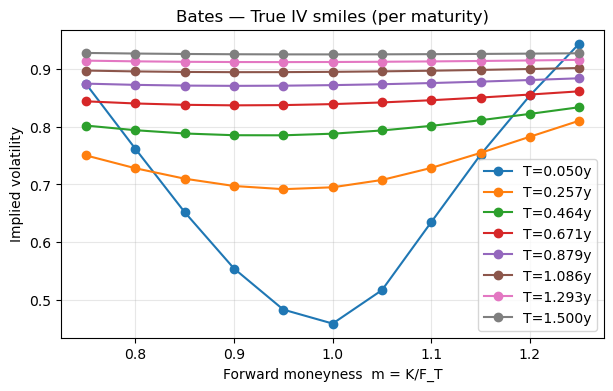

Label repriced clamp count: 0


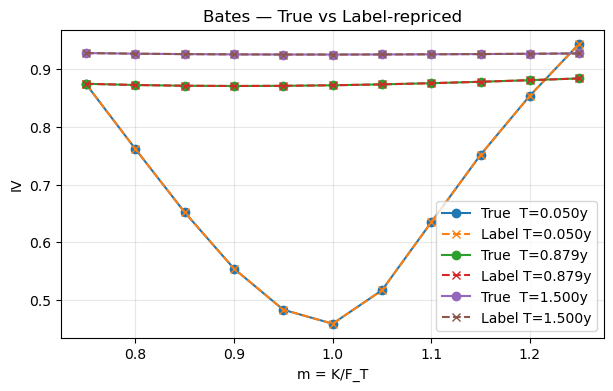

Per-T RMSE (label): [1.2300593349461255e-08, 1.1443478403521606e-08, 1.0047715515147014e-08, 1.119215445781377e-08, 1.0916955544376748e-08, 1.4809231560952317e-08, 1.4259539678361952e-08, 1.572656509849651e-08]
Bates net clamp count: 0


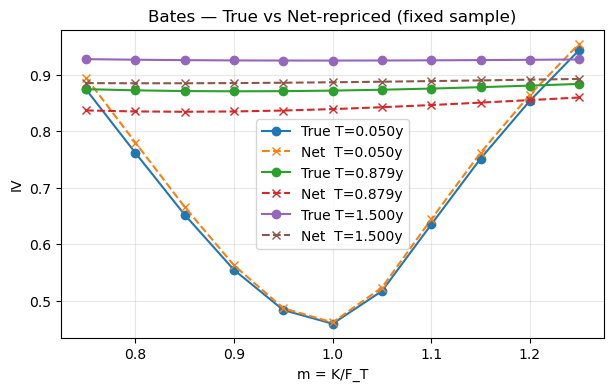

Per-T RMSE (net): [0.011734423546594529, 0.013313636585711554, 0.02268886582864745, 0.02845232811527277, 0.03228534053793443, 0.03500629840473059, 0.03700661231177964, 0.03850784081797772]
T=0.050  ATM true=0.4591  label=0.4591  net=0.4613
T=0.879  ATM true=0.8717  label=0.8717  net=0.8390
T=1.500  ATM true=0.9249  label=0.9249  net=0.8865


In [279]:
# ===== Bates — diagnostics on ONE fixed TEST sample (z-scored labels) =====

i_fixed = 0
idx_global = te_b[i_fixed]          # map to original arrays if you ever need them (aux_b, etc.)

ten = tenors_b
m   = m_grid_b
mid = len(ten) // 2

# ---- True IV from stored total variance in ds_te_b
tw_true = ds_te_b.X[i_fixed, 0].cpu().numpy()                # [nT, nM] total variance
iv_true = np.sqrt(np.maximum(tw_true / ten[:, None], 1e-12)) # -> [nT, nM]

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
for t_idx, T in enumerate(ten):
    plt.plot(m, iv_true[t_idx], "o-", label=f"T={T:.3f}y")
plt.xlabel("Forward moneyness  m = K/F_T"); plt.ylabel("Implied volatility")
plt.title("Bates — True IV smiles (per maturity)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# ---- market inputs for this sample
S_i, r_i, q_i = map(float, aux_te_b[i_fixed])

# ---- Label repriced: un-zscore ds_te_b.y[i_fixed] to original scale, then reprice
z_lab = ds_te_b.y[i_fixed].cpu().numpy()                     # z-scored params
p_lab = y_mean_b + y_std_b * z_lab                           # back to original scale
P_true = BatesParams(*[float(x) for x in p_lab])             # BatesParams in original units

iv_lab, mask_lab = iv_surface_forward_grid_with_mask(bates_price, P_true, S_i, r_i, q_i, m, ten)
print("Label repriced clamp count:", int(mask_lab.sum()))

plt.figure(figsize=(7,4))
for t in [0, mid, -1]:
    plt.plot(m, iv_true[t],  "o-",  label=f"True  T={ten[t]:.3f}y")
    plt.plot(m, iv_lab[t],   "x--", label=f"Label T={ten[t]:.3f}y")
plt.xlabel("m = K/F_T"); plt.ylabel("IV"); plt.title("Bates — True vs Label-repriced")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

print("Per-T RMSE (label):", per_t_rmse(iv_true, iv_lab))

# ---- Net repriced: predict z, un-z using model's own scaler buffers, apply constraints, reprice
bates_net.eval()
with torch.no_grad():
    pred_z = bates_net(ds_te_b.X[i_fixed:i_fixed+1].to(device))             # [1,8] z-scored
    params_vec = bates_unz_and_constrain_from_model(pred_z, bates_net)[0]   # [8], original scale (constrained)
params_b = [float(x) for x in params_vec.cpu().numpy()]
P_hat = BatesParams(*params_b)

iv_hat, mask_net = iv_surface_forward_grid_with_mask(bates_price, P_hat, S_i, r_i, q_i, m, ten)
print("Bates net clamp count:", int(mask_net.sum()))

plt.figure(figsize=(7,4))
for t in [0, mid, -1]:
    plt.plot(m, iv_true[t], "o-",  label=f"True T={ten[t]:.3f}y")
    plt.plot(m, iv_hat[t],  "x--", label=f"Net  T={ten[t]:.3f}y")
plt.xlabel("m = K/F_T"); plt.ylabel("IV"); plt.title("Bates — True vs Net-repriced (fixed sample)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# ---- Diagnostics
print("Per-T RMSE (net):", per_t_rmse(iv_true, iv_hat))

j_atm = int(np.argmin(np.abs(m - 1.0)))
for t in [0, mid, -1]:
    print(f"T={ten[t]:.3f}  ATM true={iv_true[t, j_atm]:.4f}  "
          f"label={iv_lab[t, j_atm]:.4f}  net={iv_hat[t, j_atm]:.4f}")


In [281]:
# Compare parameters for this sample
i = 0
P_true = BatesParams(*ds_te.y[i].numpy())
with torch.no_grad():
    z = bates_net(ds_te.X[i:i+1].to(device)).cpu().numpy().ravel()
kappa,theta,sigma,rho,v0,lam,muJ,sigJ = z
theta=max(theta,1e-4); sigma=max(abs(sigma),1e-4); v0=max(abs(v0),1e-6)
lam=max(abs(lam),1e-6); sigJ=max(abs(sigJ),1e-6); rho=float(np.tanh(rho))
P_hat = BatesParams(kappa,theta,sigma,rho,v0,lam,muJ,sigJ)
print("TRUE:", P_true); print("PRED:", P_hat)


TRUE: BatesParams(kappa=1.3831514, theta=0.21452077, sigma=0.7685461, rho=-0.43792757, v0=0.049830426, lam=0.27665037, muJ=0.036966316, sigJ=0.2605666)
PRED: BatesParams(kappa=0.7759196, theta=0.0001, sigma=1.8873451, rho=-0.10249541699886322, v0=0.43086445, lam=1.7460129, muJ=0.84547985, sigJ=1.814595)


### Kou (double-exponential jumps)

In [297]:

@dataclass
class KouParams:
    sigma: float   # diffusion vol
    lam: float     # jump intensity (Poisson)
    p: float       # prob of upward jump
    eta1: float    # rate of upward double-exponential
    eta2: float    # rate of downward double-exponential


def kou_cf(params: KouParams, S: float, r: float, q: float, T: float):
    sigma, lam, p, eta1, eta2 = params.sigma, params.lam, params.p, params.eta1, params.eta2
    # moment of e^J - 1  (requires eta1>1; eta2>0)
    kappa = p*(eta1/(eta1 - 1.0)) + (1.0 - p)*(eta2/(eta2 + 1.0)) - 1.0

    def cf(u: np.ndarray) -> np.ndarray:
        iu = 1j * u
        # risk-neutral drift includes -lam*kappa
        drift = np.log(S) + (r - q - lam * kappa) * T
        phi_jump = p * (eta1 / (eta1 - iu)) + (1.0 - p) * (eta2 / (eta2 + iu))
        return (np.exp(iu * drift)
                * np.exp(-0.5 * sigma * sigma * u * u * T)
                * np.exp(lam * T * (phi_jump - 1.0)))
    return cf

def kou_price(S: float, K: float, T: float, r: float, q: float, p: KouParams) -> float:
    cf = kou_cf(p, S, r, q, T)
    # same N/L schedule
    N = 2048 if T < 0.08 else (1024 if T < 0.20 else 512)
    L = 14.0
    return cos_price_call_cf(cf, S, K, T, r, q, L=L, N=N)


In [298]:
# ===== Kou dataset (forward-moneyness + clamped IV) =====
def sample_kou_params(n: int):
    out=[]
    for _ in range(n):
        sigma = rng.uniform(0.05, 0.60)
        lam   = rng.uniform(0.05, 2.00)
        p     = rng.uniform(0.20, 0.80)
        eta1  = rng.uniform(1.20, 10.0)   # must be >1
        eta2  = rng.uniform(1.20, 10.0)
        out.append(KouParams(sigma, lam, p, eta1, eta2))
    return out

def make_kou_dataset_norm(N_samples=800, nT=8, nM=11,
                          S_range=(50.0, 200.0), r_range=(-0.01, 0.05),
                          q_range=(0.0, 0.04),
                          T_min=0.05, T_max=1.2, m_grid=(0.85, 1.15)):
    tenors = np.linspace(T_min, T_max, nT)
    m = np.linspace(m_grid[0], m_grid[1], nM)   # forward moneyness
    X = np.zeros((N_samples,1,nT,nM), np.float32)      # total variance
    y = np.zeros((N_samples,5), np.float32)            # Kou params
    aux = np.zeros((N_samples,3), np.float32)          # [S,r,q]

    for i, p in enumerate(sample_kou_params(N_samples)):
        S = rng.uniform(*S_range)
        r = rng.uniform(*r_range)
        q = rng.uniform(*q_range)
        aux[i] = [S, r, q]

        iv = iv_surface_forward_grid(kou_price, p, S, r, q, m, tenors)
        X[i,0] = np.maximum(iv, 1e-8)**2 * tenors[:,None]  # store total variance
        y[i]   = np.array([p.sigma, p.lam, p.p, p.eta1, p.eta2], np.float32)

    return X, y, tenors, m, aux

# ---- build data + z-score on TRAIN ONLY
Xk, yk, ten_k, m_k, aux_k = make_kou_dataset_norm()

perm_k = rng.permutation(len(Xk))
N = len(Xk)
tr_k, va_k, te_k = perm_k[:int(0.75*N)], perm_k[int(0.75*N):int(0.9*N)], perm_k[int(0.9*N):]

y_mean_k = yk[tr_k].mean(axis=0).astype(np.float32)
y_std_k  = (yk[tr_k].std(axis=0) + 1e-8).astype(np.float32)
y_z_k    = ((yk - y_mean_k) / y_std_k).astype(np.float32)

ds_tr_k = SurfaceDataset(Xk[tr_k], y_z_k[tr_k])
ds_va_k = SurfaceDataset(Xk[va_k], y_z_k[va_k])
ds_te_k = SurfaceDataset(Xk[te_k], y_z_k[te_k])
aux_tr_k, aux_va_k, aux_te_k = aux_k[tr_k], aux_k[va_k], aux_k[te_k]


In [299]:
# Your CNN head that outputs z-scored params (reuse Heston/Bates head)
kou_net = SurfaceCalibratorZ(out_dim=5).to(device)

opt = torch.optim.AdamW(kou_net.parameters(), lr=3e-3, weight_decay=1e-4)
for ep in range(40):
    kou_net.train(); tr_loss = 0.0
    for xb, yb in DataLoader(ds_tr_k, batch_size=32, shuffle=True):
        xb, yb = xb.to(device), yb.to(device)
        pred_z = kou_net(xb)
        loss = F.mse_loss(pred_z, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()*xb.size(0)

    kou_net.eval(); vl = 0.0; n = 0
    with torch.no_grad():
        for xb, yb in DataLoader(ds_va_k, batch_size=64):
            xb, yb = xb.to(device), yb.to(device)
            vl += F.mse_loss(kou_net(xb), yb, reduction="sum").item(); n += xb.size(0)

    if ep % 5 == 0:
        print(f"[Kou] Epoch {ep:02d} | train {tr_loss/len(ds_tr_k):.5f} | val {vl/n:.5f}")


[Kou] Epoch 00 | train 2.16228 | val 4.47792
[Kou] Epoch 05 | train 0.70522 | val 3.74413
[Kou] Epoch 10 | train 0.65875 | val 3.65980
[Kou] Epoch 15 | train 0.65051 | val 3.39320
[Kou] Epoch 20 | train 0.63110 | val 3.44986
[Kou] Epoch 25 | train 0.62466 | val 3.32252
[Kou] Epoch 30 | train 0.62050 | val 3.60093
[Kou] Epoch 35 | train 0.62290 | val 3.57711


In [300]:
def kou_unz_and_constrain(pred_z: torch.Tensor,
                          y_mean: np.ndarray, y_std: np.ndarray) -> torch.Tensor:
    """
    Map z-scored outputs -> original scale, then to valid Kou domain.
    Returns [sigma, lam, p, eta1, eta2].
    """
    mean = torch.tensor(y_mean, device=pred_z.device)
    std  = torch.tensor(y_std,  device=pred_z.device)
    p = pred_z * std + mean

    # Hard bounds consistent with sampler (keeps smiles realistic)
    sigma = torch.clamp(p[...,0], 0.02, 0.60)
    lam   = torch.clamp(p[...,1], 0.00, 2.00)
    p_up  = torch.sigmoid(p[...,2])               # (0,1)
    eta1  = torch.clamp(p[...,3], 1.10, 10.0)     # >1
    eta2  = torch.clamp(p[...,4], 1.10, 10.0)

    return torch.stack([sigma, lam, p_up, eta1, eta2], dim=-1)



In [301]:
def repricing_rmse_kou_norm(model: nn.Module,
                            X_ds, y_ds, aux_ds,
                            tenors, m_grid,
                            S_default=100.0, r_default=0.01, q_default=0.0) -> float:
    model.eval(); errs=[]
    with torch.no_grad():
        N = X_ds.shape[0]
        for i in range(N):
            xb = X_ds[i:i+1].to(device)
            pred_z = model(xb)
            params_t = kou_unz_and_constrain(pred_z, y_mean_k, y_std_k)[0].cpu().numpy()
            sigma, lam, p_up, eta1, eta2 = [float(v) for v in params_t]
            P = KouParams(sigma, lam, p_up, eta1, eta2)

            if aux_ds is None:
                S, r, q = S_default, r_default, q_default
            else:
                row = aux_ds[i]
                if isinstance(row, torch.Tensor):
                    S, r, q = [float(v) for v in row.tolist()]
                else:
                    S, r, q = [float(v) for v in np.asarray(row).tolist()]

            iv_hat = iv_surface_forward_grid(kou_price, P, S, r, q, m_grid, tenors)
            tw_true = X_ds[i,0].cpu().numpy()
            iv_true = np.sqrt(np.maximum(tw_true / tenors[:,None], 1e-12))
            mask = np.isfinite(iv_true) & np.isfinite(iv_hat)
            errs.append(float(np.sqrt(np.nanmean((iv_true[mask] - iv_hat[mask])**2))))
    return float(np.mean(errs))

rmse_kou = repricing_rmse_kou_norm(kou_net, ds_te_k.X, ds_te_k.y, torch.tensor(aux_te_k),
                                   ten_k, m_k)
print("Kou (forward-moneyness) IV RMSE:", f"{rmse_kou:.6e}")



Kou (forward-moneyness) IV RMSE: 5.817621e-02


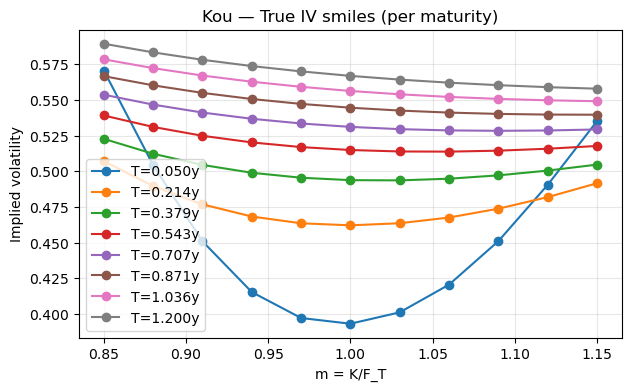

Kou label clamp count: 0


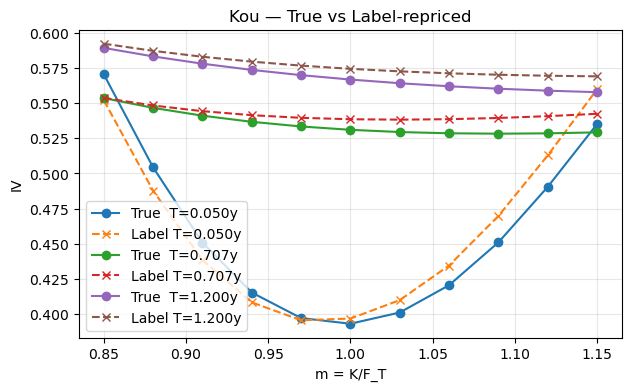

Per-T RMSE (label): [0.015282167069320727, 0.01068866560275271, 0.009258237961850681, 0.008625217034011127, 0.008288800311679652, 0.008087425387448157, 0.007957659927589442, 0.007870960023032884]
Kou (used) params: 0.3176974654197693 1.240061640739441 0.64277184009552 4.358345985412598 6.093292236328125
Kou net clamp count: 0


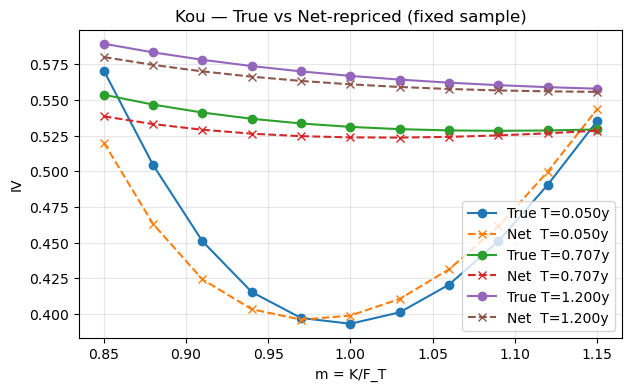

Per-T RMSE (net): [0.022544267283121793, 0.012740751296595444, 0.010773837078241142, 0.009757162768485123, 0.008912187316792107, 0.008077562998727196, 0.007214076784408231, 0.006312964053333157]
T=0.050  ATM true=0.3932  label=0.3969  net=0.3989
T=0.707  ATM true=0.5310  label=0.5386  net=0.5237
T=1.200  ATM true=0.5668  label=0.5744  net=0.5608


In [302]:
import matplotlib.pyplot as plt

def iv_surface_forward_grid_with_mask_kou(price_fn, params, S, r, q, m_grid, tenors):
    nT, nM = len(tenors), len(m_grid)
    iv = np.zeros((nT, nM), dtype=np.float64)
    mask = np.zeros((nT, nM), dtype=np.int32)
    for i, T in enumerate(tenors):
        disc_q = math.exp(-q*T); disc_r = math.exp(-r*T)
        FT = S * math.exp((r - q) * T); Ks = (m_grid * FT).astype(float)
        for j, K in enumerate(Ks):
            p = float(kou_price(S, K, float(T), r, q, params))
            lb = max(0.0, S*disc_q - K*disc_r); ub = S*disc_q
            if not np.isfinite(p): p = lb + 1e-12
            p_c = float(np.clip(p, lb + 1e-12, ub - 1e-12))
            mask[i, j] = int(p_c != p)
            iv[i, j] = implied_vol_call(S, K, float(T), r, q, p_c)
    return iv, mask

def per_t_rmse(a,b):
    out=[]
    for t in range(a.shape[0]):
        msk = np.isfinite(a[t]) & np.isfinite(b[t])
        out.append(float(np.sqrt(np.nanmean((a[t][msk]-b[t][msk])**2))))
    return out

# ----- choose a fixed test sample -----
i_fixed_k = 0
ten, m = ten_k, m_k

# true IV from stored total variance
tw_true = ds_te_k.X[i_fixed_k, 0].cpu().numpy()
iv_true = np.sqrt(np.maximum(tw_true / ten[:,None], 1e-12))

S_i, r_i, q_i = map(float, aux_te_k[i_fixed_k])

# -------- true smiles
plt.figure(figsize=(7,4))
for t_idx, T in enumerate(ten):
    plt.plot(m, iv_true[t_idx], "o-", label=f"T={T:.3f}y")
plt.xlabel("m = K/F_T"); plt.ylabel("Implied volatility")
plt.title("Kou — True IV smiles (per maturity)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# -------- True vs LABEL-repriced (un-z labels + same constraints)
z_lab = ds_te_k.y[i_fixed_k].cpu().numpy()
p_lab = y_mean_k + y_std_k * z_lab
p_lab = np.array([
    np.clip(p_lab[0], 0.02, 0.60),
    np.clip(p_lab[1], 0.00, 2.00),
    1.0/(1.0 + np.exp(-p_lab[2])),
    np.clip(p_lab[3], 1.10, 10.0),
    np.clip(p_lab[4], 1.10, 10.0),
], dtype=np.float64)
P_label = KouParams(*[float(x) for x in p_lab])

iv_lab, mask_lab = iv_surface_forward_grid_with_mask_kou(kou_price, P_label, S_i, r_i, q_i, m, ten)
print("Kou label clamp count:", int(mask_lab.sum()))

mid = len(ten)//2
plt.figure(figsize=(7,4))
for t in [0, mid, -1]:
    plt.plot(m, iv_true[t], "o-",  label=f"True  T={ten[t]:.3f}y")
    plt.plot(m, iv_lab[t],  "x--", label=f"Label T={ten[t]:.3f}y")
plt.xlabel("m = K/F_T"); plt.ylabel("IV"); plt.title("Kou — True vs Label-repriced")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()
print("Per-T RMSE (label):", per_t_rmse(iv_true, iv_lab))

# -------- True vs NET-repriced (constrained)
kou_net.eval()
with torch.no_grad():
    pred_z = kou_net(ds_te_k.X[i_fixed_k:i_fixed_k+1].to(device))
    params_k = kou_unz_and_constrain(pred_z, y_mean_k, y_std_k)[0].cpu().numpy()
sigma, lam, p_up, eta1, eta2 = [float(v) for v in params_k]
print("Kou (used) params:", sigma, lam, p_up, eta1, eta2)

P_hat = KouParams(sigma, lam, p_up, eta1, eta2)
iv_hat, mask_net = iv_surface_forward_grid_with_mask_kou(kou_price, P_hat, S_i, r_i, q_i, m, ten)
print("Kou net clamp count:", int(mask_net.sum()))

plt.figure(figsize=(7,4))
for t in [0, mid, -1]:
    plt.plot(m, iv_true[t], "o-",  label=f"True T={ten[t]:.3f}y")
    plt.plot(m, iv_hat[t],  "x--", label=f"Net  T={ten[t]:.3f}y")
plt.xlabel("m = K/F_T"); plt.ylabel("IV"); plt.title("Kou — True vs Net-repriced (fixed sample)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

print("Per-T RMSE (net):", per_t_rmse(iv_true, iv_hat))
j_atm = int(np.argmin(np.abs(m-1.0)))
for t in [0, mid, -1]:
    print(f"T={ten[t]:.3f}  ATM true={iv_true[t,j_atm]:.4f}  label={iv_lab[t,j_atm]:.4f}  net={iv_hat[t,j_atm]:.4f}")


### Side-by-side comparison

In [328]:
# Print RMSEs gathered
print({
    "Heston_IV_RMSE": round(rmse_heston, 5),
    "Bates_IV_RMSE": round(rmse_bates, 5),
    "Kou_IV_RMSE": round(rmse_kou, 5),
})


{'Heston_IV_RMSE': 0.07345, 'Bates_IV_RMSE': 0.02595, 'Kou_IV_RMSE': 0.05818}


### SPY Option Market

[FIT  SPY 2025-12-12]  T=0.088y  q=0.0134  RMSEs  H=0.0240  B=0.0109  K=0.0268
[TEST SPY 2025-12-31] T=0.140y  q=0.0134  OOS RMSEs  H=0.0297  B=0.0219  K=0.0134


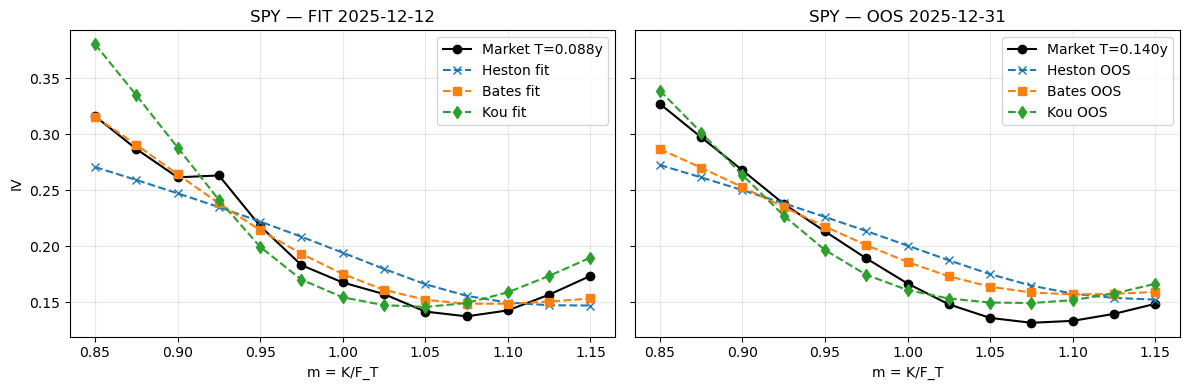

In [337]:
# === Real-data calibration & simple OOS backtest (yfinance) ===
# Calibrate on a near expiry; test by repricing a farther expiry with the same params.

import numpy as np, pandas as pd, math, warnings
from dataclasses import dataclass
from typing import Optional, Tuple
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import yfinance as yf

# ===Small market utilities ===

def _last_close(ticker: str) -> float:
    t = yf.Ticker(ticker)
    h = t.history(period="5d", interval="1d").dropna()
    if h.empty:
        raise ValueError(f"No price for {ticker}")
    return float(h["Close"].iloc[-1])

def _risk_free_from_irx(default: float = 0.04) -> float:
    try:
        y = _last_close("^IRX")  
        r = max(0.0, float(y)/100.0)
        return r
    except Exception:
        return default

def _dividend_yield_estimate(ticker: str, S: float, fallback: float = 0.015) -> float:
    try:
        t = yf.Ticker(ticker)
        div = t.dividends
        if div is None or len(div)==0:
            return fallback
        last_year = div[div.index >= (div.index.max() - pd.Timedelta(days=365))].sum()
        dy = float(last_year)/float(S)
        # continuous compounding approx:
        return max(0.0, min(0.06, dy))
    except Exception:
        return fallback

def _yahoo_chain_df(ticker: str, expiry: str) -> pd.DataFrame:
    """Return merged calls/puts with mid prices & strikes."""
    t = yf.Ticker(ticker)
    oc = t.option_chain(expiry)
    calls, puts = oc.calls.copy(), oc.puts.copy()
    # normalize column names a bit
    def _mid(df):
        bid = df.get("bid"); ask = df.get("ask")
        last = df.get("lastPrice")
        if bid is not None and ask is not None and np.isfinite(bid).all() and np.isfinite(ask).all():
            return 0.5*(bid.astype(float) + ask.astype(float))
        return last.astype(float)
    calls["mid"] = _mid(calls)
    puts["mid"]  = _mid(puts)
    calls["type"] = "C"; puts["type"]="P"
    df = pd.concat([calls[["strike","mid","impliedVolatility","type"]],
                    puts[["strike","mid","impliedVolatility","type"]]],
                   ignore_index=True).rename(columns={"strike":"K","impliedVolatility":"iv_yf"})
    return df

def _nearest_expiries(ticker: str, dte_fit: int = 30, dte_test: int = 60) -> Tuple[str,str]:
    t = yf.Ticker(ticker)
    exps = t.options
    if not exps:
        raise ValueError("No listed expiries.")

    # make everything tz-naive
    now_naive = pd.Timestamp.utcnow().tz_localize(None)
    today = now_naive.normalize()
    exps_dt = pd.to_datetime(exps).tz_localize(None)

    dtes = (exps_dt - today).days
    fit_idx  = int(np.argmin(np.abs(dtes - dte_fit)))
    test_idx = int(np.argmin(np.abs(dtes - dte_test)))
    return exps[fit_idx], exps[test_idx]

# ===Build market smile on forward grid m=K/F ===

def market_smile_on_m(ticker: str, expiry: str, S: float, r: float, q: Optional[float],
                      m_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float, float]:
    df = _yahoo_chain_df(ticker, expiry)

    # tz-naive times -> year fraction
    exp_ts = pd.to_datetime(expiry).tz_localize(None)
    now_naive = pd.Timestamp.utcnow().tz_localize(None)
    T = float(max(1.0/365.0, (exp_ts - now_naive) / pd.Timedelta(days=365)))

    if q is None:
        q = _dividend_yield_estimate(ticker, S)

    F = S * math.exp((r - q) * T)

    # use CALLS mid wherever possible
    calls = df[df["type"]=="C"][["K","mid"]].dropna().rename(columns={"mid":"c_mid"})
    puts  = df[df["type"]=="P"][["K","mid"]].dropna().rename(columns={"mid":"p_mid"})
    merged = pd.merge(calls, puts, on="K", how="outer")
    disc_r, disc_q = math.exp(-r*T), math.exp(-q*T)

    def call_price_row(row):
        if np.isfinite(row.get("c_mid", np.nan)):
            return float(row["c_mid"])
        # parity: C = P + S e^{-qT} - K e^{-rT}
        if np.isfinite(row.get("p_mid", np.nan)):
            return float(row["p_mid"] + S*disc_q - float(row["K"])*disc_r)
        return np.nan

    merged["c_price"] = merged.apply(call_price_row, axis=1)
    merged = merged.dropna(subset=["c_price","K"]).copy()
    merged["m"] = merged["K"].astype(float)/F

    # invert to IV
    ivs = []
    for K, cp in zip(merged["K"].astype(float).values, merged["c_price"].astype(float).values):
        lb = max(0.0, S*disc_q - K*disc_r); ub = S*disc_q
        p = float(np.clip(cp, lb+1e-12, ub-1e-12))
        try:
            ivs.append(implied_vol_call(S, float(K), T, r, q, p))
        except Exception:
            ivs.append(np.nan)
    merged["iv"] = np.array(ivs, float)
    merged = merged.replace([np.inf,-np.inf], np.nan).dropna(subset=["iv","m"])

    # interpolate to uniform m-grid
    merged = merged.sort_values("m")
    iv_on_grid = np.interp(m_grid, merged["m"].values, merged["iv"].values)
    return m_grid, iv_on_grid.astype(float), float(T), float(q)

# ===Model param containers & transforms ===

@dataclass
class HestonParams:
    kappa: float; theta: float; sigma: float; rho: float; v0: float

@dataclass
class BatesParams:
    kappa: float; theta: float; sigma: float; rho: float; v0: float
    lam: float;  muJ: float;  sigJ: float

@dataclass
class KouParams:
    sigma: float; lam: float; p: float; eta1: float; eta2: float

def heston_from_u(u):
    kappa = np.exp(u[0]); theta = np.exp(u[1]); sigma = np.exp(u[2]); rho = np.tanh(u[3]); v0 = np.exp(u[4])
    if 2*kappa*theta <= sigma*sigma: theta = (sigma*sigma)/(2*kappa) + 1e-4
    return HestonParams(kappa,theta,sigma,rho,v0)

def bates_from_u(u):
    h = heston_from_u(u[:5])
    lam = np.exp(u[5]); muJ = np.clip(u[6], -0.5, 0.5); sigJ = np.exp(u[7])
    return BatesParams(h.kappa,h.theta,h.sigma,h.rho,h.v0,lam,muJ,sigJ)

def kou_from_u(u):
    sigma = np.exp(u[0]); lam = np.exp(u[1]); p = 1/(1+np.exp(-u[2])); eta1 = 1.0 + np.exp(u[3]); eta2 = np.exp(u[4])
    return KouParams(sigma,lam,p,eta1,eta2)

# one-tenor IV from each model
def _iv_single_T(price_fn, params, S, r, q, m_grid, T):
    F = S*math.exp((r - q)*T); Ks = (m_grid*F).astype(float)
    iv = np.zeros_like(m_grid, dtype=float)
    disc_r, disc_q = math.exp(-r*T), math.exp(-q*T)
    for j, K in enumerate(Ks):
        p = float(price_fn(S, float(K), T, r, q, params))
        lb = max(0.0, S*disc_q - K*disc_r); ub = S*disc_q
        p_c = float(np.clip(p, lb+1e-12, ub-1e-12))
        iv[j] = implied_vol_call(S, float(K), T, r, q, p_c)
    return iv

# objectives
def _w(m): return 1.0/(0.05 + (m-1.0)**2)

def obj_h(u, m, iv_mkt, S, r, q, T): return np.sqrt(_w(m)) * (_iv_single_T(heston_price, heston_from_u(u), S,r,q,m,T) - iv_mkt)
def obj_b(u, m, iv_mkt, S, r, q, T): return np.sqrt(_w(m)) * (_iv_single_T(bates_price,  bates_from_u(u),  S,r,q,m,T) - iv_mkt)
def obj_k(u, m, iv_mkt, S, r, q, T): return np.sqrt(_w(m)) * (_iv_single_T(kou_price,    kou_from_u(u),    S,r,q,m,T) - iv_mkt)

def rmse(a,b):
    mask = np.isfinite(a)&np.isfinite(b)
    return float(np.sqrt(np.mean((a[mask]-b[mask])**2)))

# ===Run: fit near expiry, test on farther===

ticker = "SPY"
m_grid  = np.linspace(0.85, 1.15, 13)
S0 = _last_close(ticker)
r  = _risk_free_from_irx(default=0.04)

fit_exp, test_exp = _nearest_expiries(ticker, dte_fit=30, dte_test=60)

# near expiry (fit)
m_fit, iv_fit, T_fit, q_fit = market_smile_on_m(ticker, fit_exp, S0, r, None, m_grid)

# far expiry (for OOS test)
m_test, iv_test, T_test, q_test = market_smile_on_m(ticker, test_exp, S0, r, q_fit, m_grid)

# calibrate
u0_h = np.array([np.log(1.5), np.log(0.04), np.log(0.5), np.arctanh(-0.5), np.log(0.04)])
u0_b = np.r_[u0_h, np.log([0.2]), 0.0, np.log(0.2)]
u0_k = np.array([np.log(0.3), np.log(0.6), 0.0, np.log(1.5), np.log(3.0)])

res_h = least_squares(obj_h, u0_h, args=(m_fit, iv_fit, S0, r, q_fit, T_fit), max_nfev=2000, verbose=0)
res_b = least_squares(obj_b, u0_b, args=(m_fit, iv_fit, S0, r, q_fit, T_fit), max_nfev=2500, verbose=0)
res_k = least_squares(obj_k, u0_k, args=(m_fit, iv_fit, S0, r, q_fit, T_fit), max_nfev=2500, verbose=0)

P_h, P_b, P_k = heston_from_u(res_h.x), bates_from_u(res_b.x), kou_from_u(res_k.x)

# in-sample fits
iv_h_fit = _iv_single_T(heston_price, P_h, S0, r, q_fit, m_fit, T_fit)
iv_b_fit = _iv_single_T(bates_price,  P_b, S0, r, q_fit, m_fit, T_fit)
iv_k_fit = _iv_single_T(kou_price,    P_k, S0, r, q_fit, m_fit, T_fit)

print(f"[FIT  {ticker} {fit_exp}]  T={T_fit:.3f}y  q={q_fit:.4f}  RMSEs  H={rmse(iv_fit,iv_h_fit):.4f}  B={rmse(iv_fit,iv_b_fit):.4f}  K={rmse(iv_fit,iv_k_fit):.4f}")

# out-of-sample: same params, longer T
iv_h_oos = _iv_single_T(heston_price, P_h, S0, r, q_fit, m_test, T_test)
iv_b_oos = _iv_single_T(bates_price,  P_b, S0, r, q_fit, m_test, T_test)
iv_k_oos = _iv_single_T(kou_price,    P_k, S0, r, q_fit, m_test, T_test)

print(f"[TEST {ticker} {test_exp}] T={T_test:.3f}y  q={q_fit:.4f}  OOS RMSEs  H={rmse(iv_test,iv_h_oos):.4f}  B={rmse(iv_test,iv_b_oos):.4f}  K={rmse(iv_test,iv_k_oos):.4f}")

# =========================
# 5) Plots (two panels)
# =========================
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

axes[0].plot(m_fit, iv_fit, "ko-", label=f"Market T={T_fit:.3f}y")
axes[0].plot(m_fit, iv_h_fit, "x--", label="Heston fit")
axes[0].plot(m_fit, iv_b_fit, "s--", label="Bates fit")
axes[0].plot(m_fit, iv_k_fit, "d--", label="Kou fit")
axes[0].set_title(f"{ticker} — FIT {fit_exp}")
axes[0].set_xlabel("m = K/F_T"); axes[0].set_ylabel("IV"); axes[0].grid(True, alpha=0.3); axes[0].legend()

axes[1].plot(m_test, iv_test, "ko-", label=f"Market T={T_test:.3f}y")
axes[1].plot(m_test, iv_h_oos, "x--", label="Heston OOS")
axes[1].plot(m_test, iv_b_oos, "s--", label="Bates OOS")
axes[1].plot(m_test, iv_k_oos, "d--", label="Kou OOS")
axes[1].set_title(f"{ticker} — OOS {test_exp}")
axes[1].set_xlabel("m = K/F_T"); axes[1].grid(True, alpha=0.3); axes[1].legend()

plt.tight_layout(); plt.show()
